# Table of Contents
* [Load data](#Load-data)
	* [paths and reads](#paths-and-reads)
	* [extracting specifics](#extracting-specifics)
* [Basic question types](#Basic-question-types)
* [Non-Diagram Questions](#Non-Diagram-Questions)
	* [bigram/trigram question phrases](#bigram/trigram-question-phrases)
	* [question length](#question-length)
	* [looking at all/some/none of the above questions](#looking-at-all/some/none-of-the-above-questions)
	* [Looking for answer text in associated lessons](#Looking-for-answer-text-in-associated-lessons)
	* [hide](#hide)
* [Templates](#Templates)


In [586]:
%%capture
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict

import cv2
import pprint
import pickle
import json
import requests
import io
import sys
import os
from binascii import b2a_hex
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
from copy import deepcopy
import glob

import json
import enchant
import pickle
import glob

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.stem.wordnet import WordNetLemmatizer

import language_check

import jsonschema
# from pdfextraction.ck12_new_schema import ck12_schema
from tqa_utils import Evaluator

from analysis_utils import *

In [392]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light bright
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Load data

## paths and reads

In [5]:
dataset_root_dir = '/Users/schwenk/wrk/stb/dataset_releases/data_release_beta6/'
file_name = 'tqa_dataset_beta7_5.json'
data_file =  dataset_root_dir + file_name

quest_evaluator = Evaluator(data_file)

In [3]:
with open(os.path.join(dataset_root_dir, file_name), 'r') as f:
    ck12_combined_dataset_raw = json.load(f)
ck12_combined_dataset = deepcopy(ck12_combined_dataset_raw)

## extracting specifics

In [520]:
lesson_text = collect_filtered_lesson_text(ck12_combined_dataset)

all_ndqs = quest_evaluator.build_question_lookup(by_type=True)['nonDiagramQuestions']
mc_questions = quest_evaluator.build_questions_by_subtype(all_ndqs)['Multiple Choice']

# Basic question types

In [452]:
combined_topics = [lesson['lessonName'] for lesson in ck12_combined_dataset]
topic_series = pd.Series(combined_topics).value_counts()

In [453]:
# topic_series[:20]
len(combined_topics)

1076

In [454]:
q_types = []
for lesson in ck12_combined_dataset:
    for question in lesson['questions']['nonDiagramQuestions'].values():
        q_types.append(question['questionSubType'])
question_counts = pd.Series(q_types).value_counts()
print('total number of questions = ' + str(question_counts.sum()))
question_counts

total number of questions = 18929


Multiple Choice      6582
True or False        5400
Fill in the Blank    3643
Matching             1711
Short Answer         1593
dtype: int64

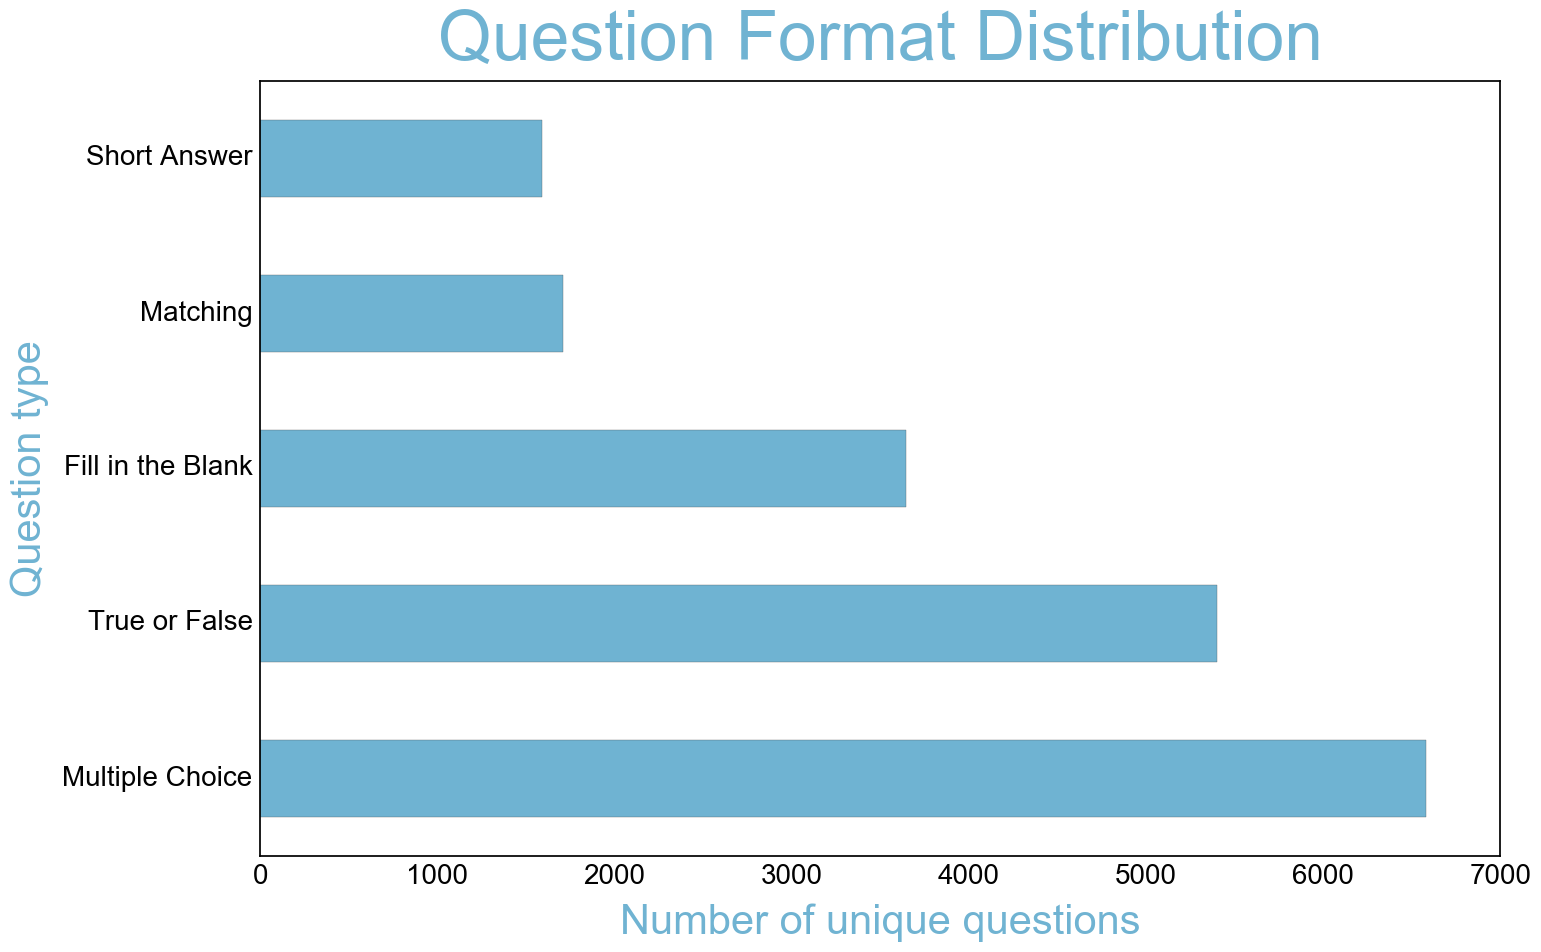

In [455]:
_ = question_counts.plot(kind="barh")
plt.title('Question Format Distribution', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Question type", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Number of unique questions", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [10]:
usable_questions = question_counts[:2].append(question_counts[3:4])

In [11]:
sum(usable_questions)

13693

# Non-Diagram Questions

## bigram/trigram question phrases

In [555]:
cached_sw = ['?', 'the', 'a', 's', "'", 'this', '.', ',', '_____', '__________', 'an']

In [556]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

### first pass

In [557]:
ndq_corpus = ''
for lesson in ck12_combined_dataset:
    for qid, quest in lesson['questions']['nonDiagramQuestions'].items():
        ndq_corpus += ' ' + quest['beingAsked']['processedText'].replace('(', ' ').replace(')', ' ')
        
q_tokens = wordpunct_tokenize(ndq_corpus)
normalized_tokens = [toke.strip().lower().encode('ascii', 'ignore').decode() for toke in q_tokens if toke.strip().lower().encode('ascii', 'ignore').decode() not in cached_sw]
    
qw_freq_d = nltk.FreqDist(normalized_tokens)
most_common_qw = qw_freq_d.most_common(20)

In [558]:
most_common_qw

[('of', 8740),
 ('is', 6556),
 ('in', 4303),
 ('to', 3415),
 ('that', 2788),
 ('are', 2578),
 ('and', 2267),
 ('which', 1691),
 ('what', 1540),
 ('by', 1214),
 ('energy', 1064),
 ('on', 1029),
 ('from', 1011),
 ('water', 987),
 ('can', 972),
 ('for', 948),
 ('when', 944),
 ('called', 892),
 ('with', 868),
 ('it', 856)]

In [10]:
print([word[0] for word in most_common_qw])

['of', 'is', 'in', 'to', 'that', 'are', 'and', 'which', 'what', 'by', 'energy', 'on', 'from', 'water', 'can', 'for', 'when', 'called', 'with', 'it']


In [465]:
phrase_bi_finder = BigramCollocationFinder.from_words(normalized_tokens)
phrase_bi_finder.apply_freq_filter(75) 
# phrase_bi_finder.nbest(bigram_measures.pmi, 10)
most_common_bigrams = []

for k,v in sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]:
    most_common_bigrams.append((' '.join(k), v))

In [466]:
sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]

[(('what', 'is'), 651),
 (('which', 'of'), 491),
 (('is', 'called'), 488),
 (('of', 'following'), 472),
 (('type', 'of'), 387),
 (('that', 'is'), 291),
 (('can', 'be'), 281),
 (('example', 'of'), 271),
 (('in', 'which'), 262),
 (('it', 'is'), 207),
 (('which', 'statement'), 196),
 (('amount', 'of'), 186),
 (('used', 'to'), 174),
 (('part', 'of'), 173),
 (('called', 'n'), 169)]

In [467]:
most_common_bigrams

[('what is', 651),
 ('which of', 491),
 ('is called', 488),
 ('of following', 472),
 ('type of', 387),
 ('that is', 291),
 ('can be', 281),
 ('example of', 271),
 ('in which', 262),
 ('it is', 207),
 ('which statement', 196),
 ('amount of', 186),
 ('used to', 174),
 ('part of', 173),
 ('called n', 169)]

In [470]:
phrase_tri_finder = TrigramCollocationFinder.from_words(normalized_tokens)
phrase_tri_finder.apply_freq_filter(30) 
# phrase_tri_finder.nbest(trigram_measures.pmi, 20)  

most_common_tri = []
three_word_qtypes = []
for k,v in sorted(phrase_tri_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:9]:
    most_common_tri.append((' '.join(k), v))
    three_word_qtypes.append(' '.join(k))

In [45]:
high_values_lessons = q_type_df[q_type_df.apply(lambda x: sum(x), axis=1) > 42] ## three word
high_values_lessons = q_type_df[q_type_df.apply(lambda x: sum(x), axis=1) > 375] ## two word

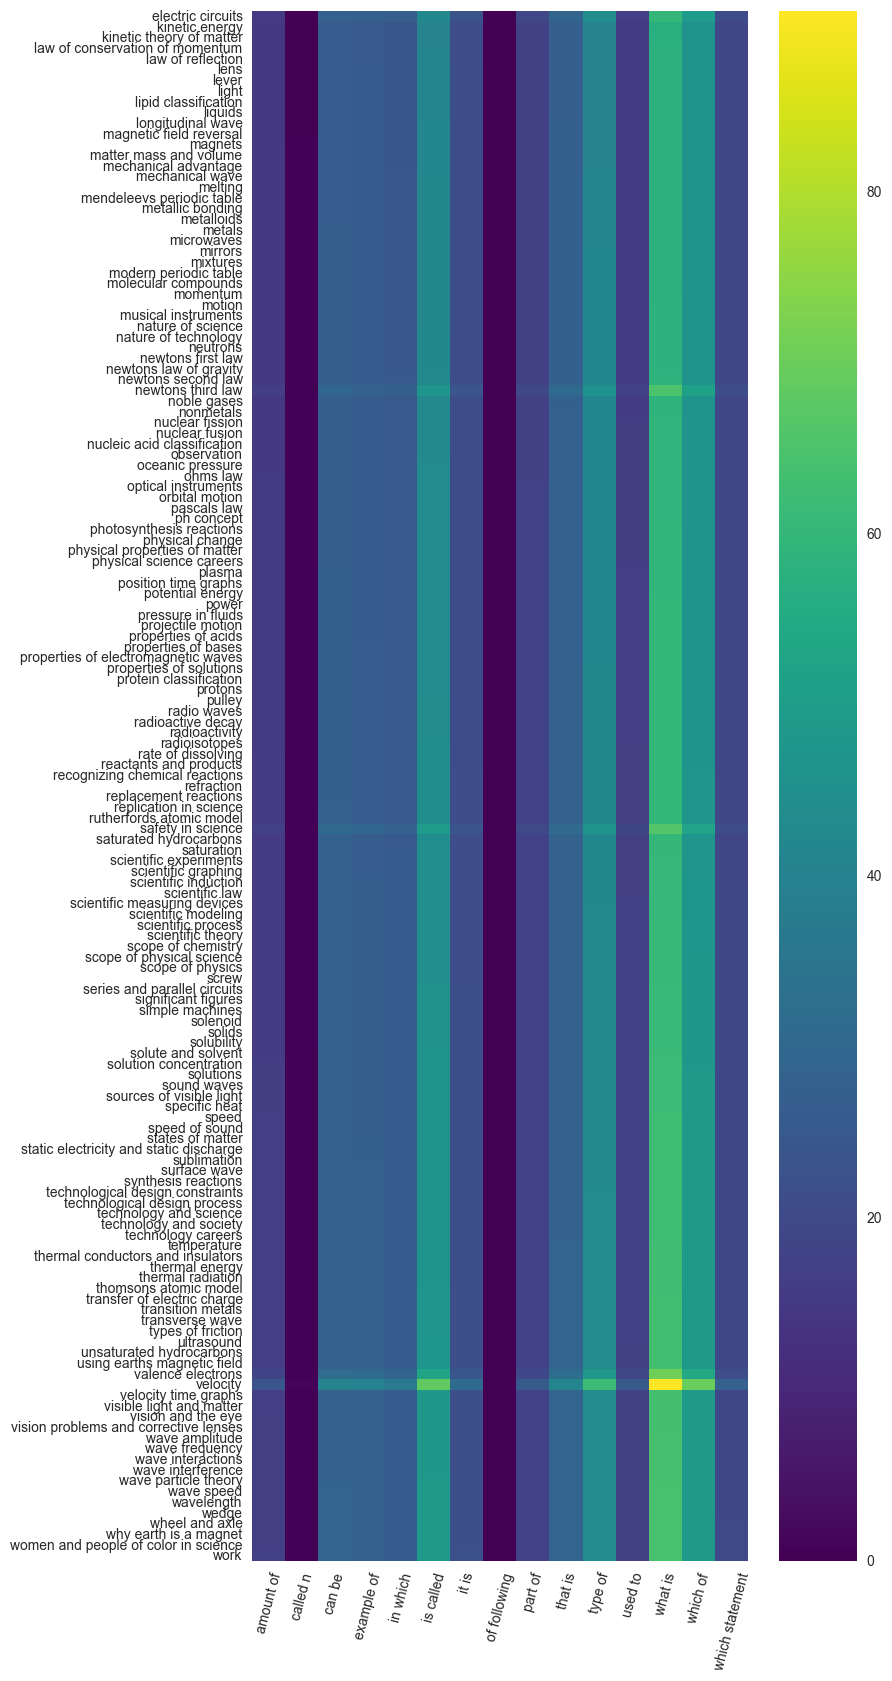

In [47]:
fig, ax = plt.subplots(figsize=(8, 20))
_ = sns.heatmap(high_values_lessons, cmap='viridis', robust=False)
_ = plt.xticks(rotation=75) 

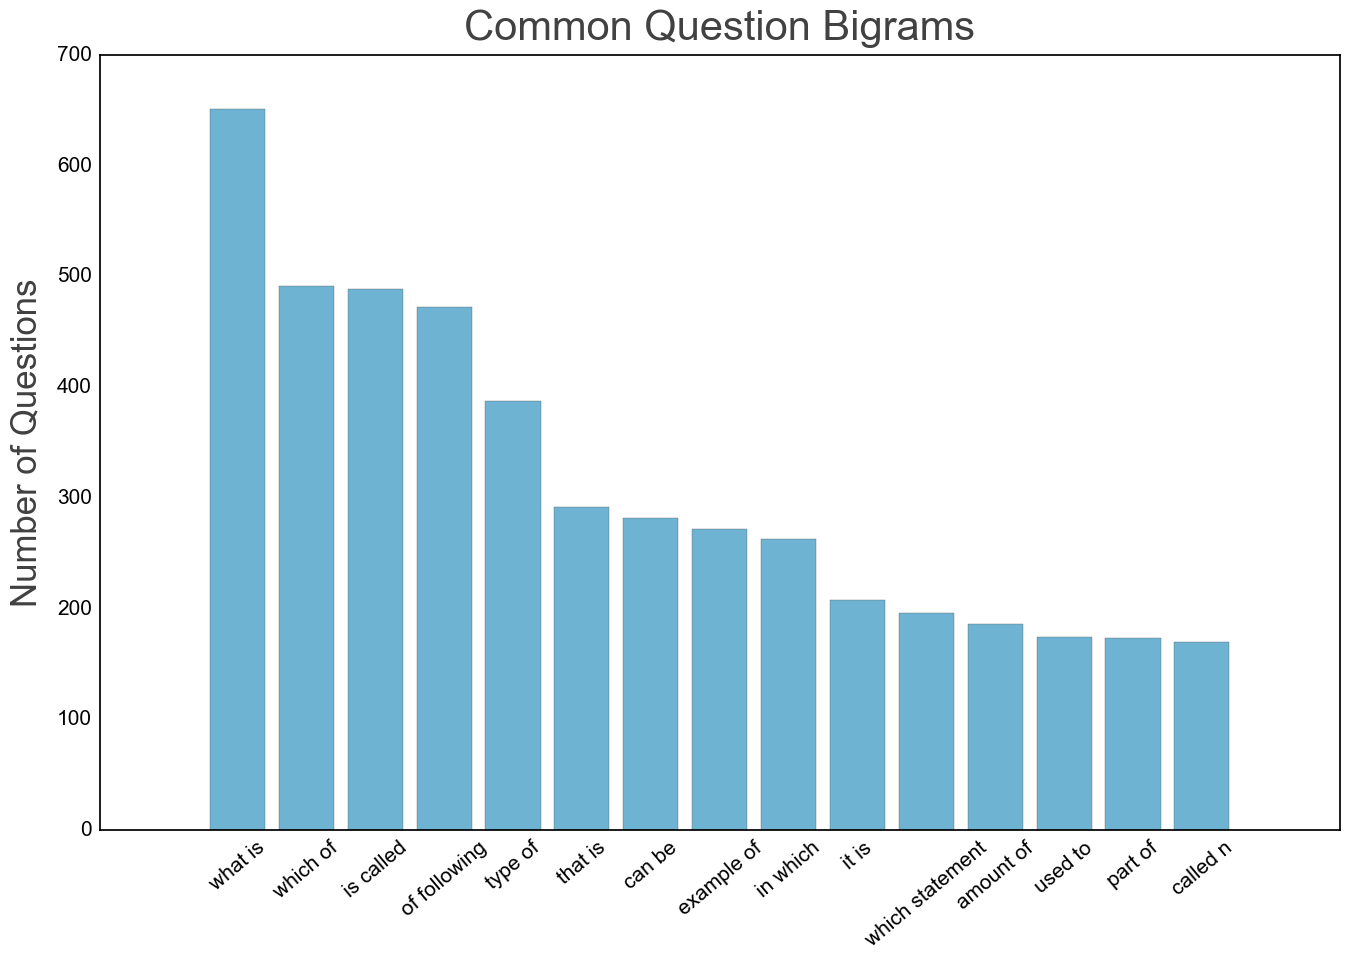

In [468]:
sorted_common = sorted(most_common_bigrams, key=lambda x: x[1], reverse=True) 

qtype = list(zip(*sorted_common))[0]
q_num = list(zip(*sorted_common))[1]
x_pos = np.arange(len(qtype))

plot_to_save = plt.bar(x_pos, q_num,align='center')
plt.xticks(x_pos, qtype, rotation=40) 

fig_labels = {
    'fig_title': 'Common Question Bigrams', 
    'x_label': '',
    'y_label': 'Number of Questions'
}

# weights = np.ones_like(array_to_hist)/len(array_to_hist)
# tick_labels = plot_to_save.get_yticks()
# plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

In [572]:
all_ndqs = quest_evaluator.build_question_lookup(by_type=True)['nonDiagramQuestions']
question_text = make_prop_series(all_ndqs, lambda x: x['beingAsked']['processedText'])
questions_sw_removed = {}
for qid, quest in all_ndqs.items():
    quest_text = quest['beingAsked']['processedText']
    quest['beingAsked']['processedText'] = ' '.join(tokenize_text(quest_text))
    questions_sw_removed[qid] = quest

In [505]:
most_common_tri

[('which of following', 392),
 ('of following is', 162),
 ('is example of', 158),
 ('is called n', 137),
 ('which statement about', 114),
 ('which of these', 89),
 ('is known as', 76),
 ('all of following', 75),
 ('process in which', 68)]

In [504]:
most_common_bigrams

[('what is', 651),
 ('which of', 491),
 ('is called', 488),
 ('of following', 472),
 ('type of', 387),
 ('that is', 291),
 ('can be', 281),
 ('example of', 271),
 ('in which', 262),
 ('it is', 207),
 ('which statement', 196),
 ('amount of', 186),
 ('used to', 174),
 ('part of', 173),
 ('called n', 169)]

In [512]:
common_answers_to_common_questions = defaultdict(list)
for qid, question in questions_sw_removed.items():
    for phrase in most_common_bigrams:
        if phrase[0] in question['beingAsked']['processedText']:
            answer_id = question['correctAnswer']['processedText']
            if answer_id not in question['answerChoices'].keys():
                continue
            answer_text = question['answerChoices'][answer_id]['processedText']
            answer_text_cleaned = ' '.join(tokenize_question(answer_text))
            if 'the above' not in answer_text:
                common_answers_to_common_questions[phrase[0]].append(answer_text)

In [513]:
for phrase, answer_series in common_answers_to_common_questions.items():
    answer_series = pd.Series(answer_series)
    print(phrase)
    print(answer_series.value_counts()[:5])
    print()

that is
false                   18
true                    17
carbon dioxide           3
control                  3
independent variable     3
dtype: int64

can be
true                 71
false                34
genital warts         3
hypothesis            2
carrying capacity     2
dtype: int64

it is
false                  41
true                   36
scientific theory       2
dependent variable      2
autosomal recessive     2
dtype: int64

called n
false                                              3
The poles line up with Earths north-south axis.    1
significant figures.                               1
dtype: int64

amount of
true       31
false      20
density     4
mass        2
volume      2
dtype: int64

what is
2         4
oxygen    2
0%        2
0         2
true      2
dtype: int64

example of
true                      36
false                     33
water                      3
Down syndrome              2
allopatric speciation.     2
dtype: int64

of following
water      

### second pass look only at start of last sentence

## question length

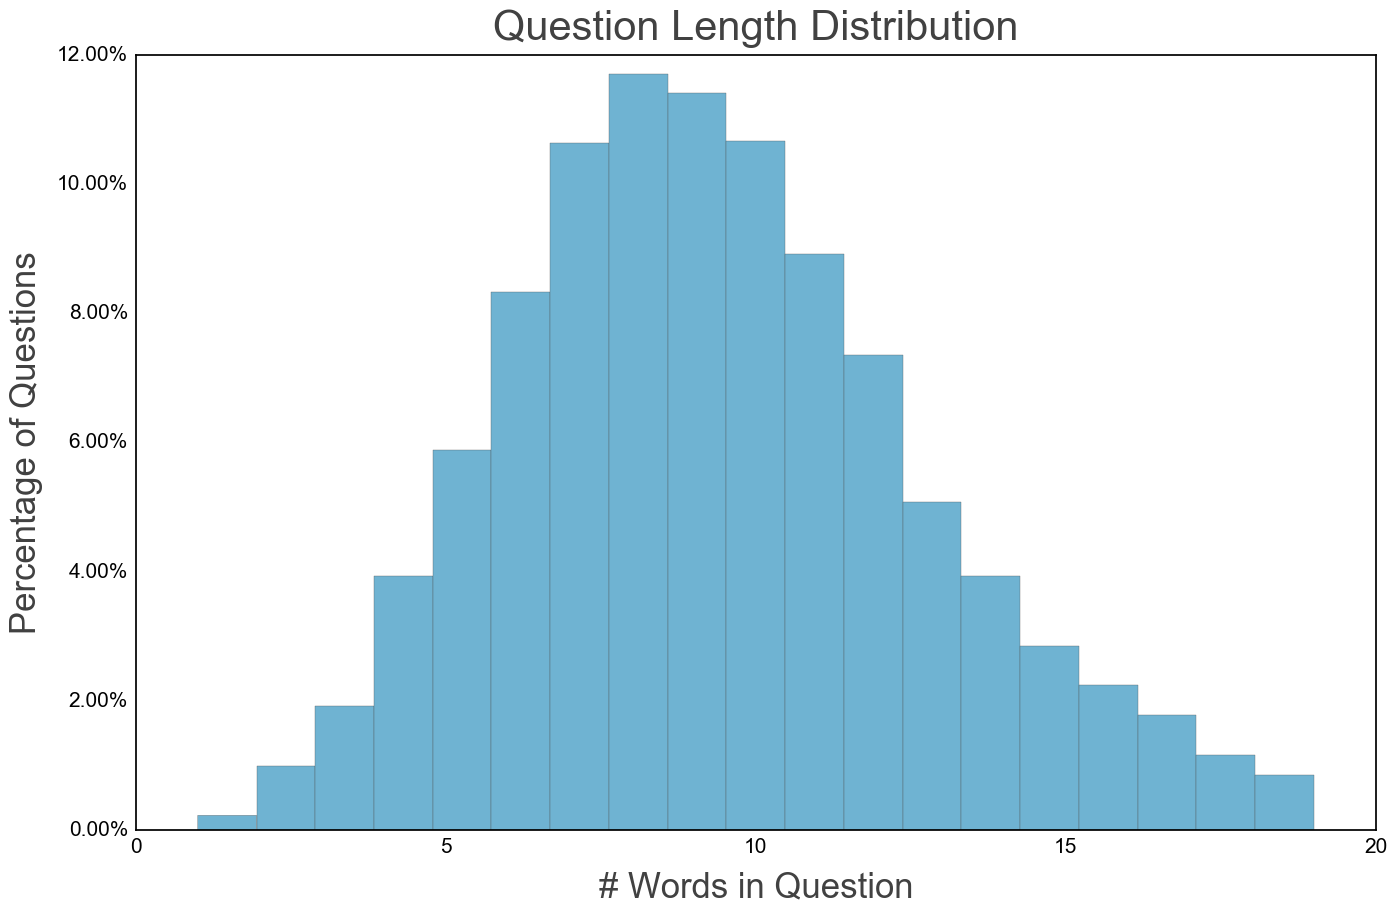

In [547]:
question_lengths = make_prop_series(all_ndqs, lambda x: len(x['beingAsked']['processedText'].split()))
question_lengths = question_lengths[question_lengths < 20]

fig_labels = {
    'fig_title': 'Question Length Distribution', 
    'x_label': '# Words in Question',
    'y_label': 'Percentage of Questions'
}
weights = np.ones_like(question_lengths)/len(question_lengths)
plot_to_save = question_lengths.hist(bins= 19, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

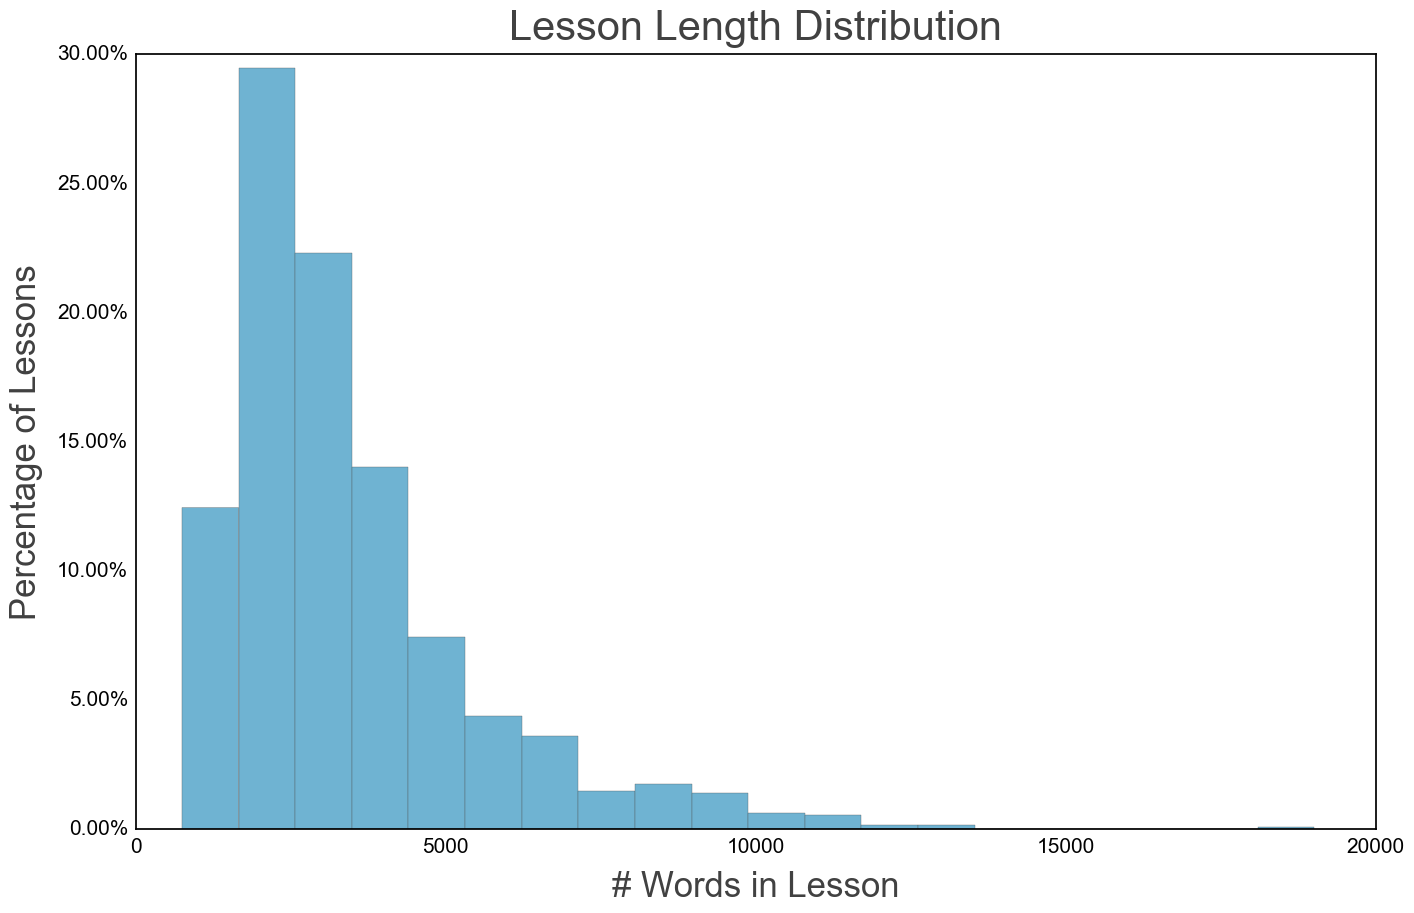

In [450]:
topic_lengths = pd.Series([len(text) for text in lesson_text.values()])

fig_labels = {
    'fig_title': 'Lesson Length Distribution', 
    'x_label': '# Words in Lesson',
    'y_label': 'Percentage of Lessons'
}
weights = np.ones_like(topic_lengths)/len(topic_lengths)
plot_to_save = topic_lengths.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

## looking at all/some/none of the above questions

In [253]:
reasoning_q_phrases = [' if ', 'what would ', 'what happens']
reasoning_questions = collect_filtered_question_text(all_ndqs, reasoning_q_phrases)

In [125]:
question_asks = {}
answer_choices_with_above = []
correct_answer_choices_with_above = []
for qid, question in mc_questions.items(): 
    question_text = question['beingAsked']['processedText']
    ans_choices = {acid: ac['processedText'] for acid, ac in question['answerChoices'].items() if 'the above' in ac['processedText'].lower()}
    if ans_choices:
        above_choice_correct = 'd' == question['correctAnswer']['processedText']
        correct_answer_choices_with_above.append(above_choice_correct)
    answer_choices_with_above += list(ans_choices.values())
    question_asks[qid] = question_text

sum(correct_answer_choices_with_above) / len(answer_choices_with_above)

len(answer_choices_with_above)

## Looking for answer text in associated lessons

In [649]:
punct_stop = list(string.punctuation)
cached_sw = stopwords.words("english") + punct_stop + list(['_____', '__________'])
lmtizer = WordNetLemmatizer()
tokenizer = wordpunct_tokenize

def filter_pos(token_list):
    tagged_tokens = nltk.pos_tag(token_list)
    filtered_tokes = [toke[0] for toke in tagged_tokens if toke[1] in ['NN', 'RB', 'NNS', 'JJ']]
    if filtered_tokes:
        return filtered_tokes
    else:
        return []

def lemmatize_and_filter_sw(tokens):
    return filter_pos([lmtizer.lemmatize(toke) for toke in wordpunct_tokenize(tokens) if toke not in cached_sw])

In [573]:
vocab_topics = ['Lesson Vocabulary', 'Vocabulary']
structural_topics = ['Summary', 'Review', 'References', 'Explore More', 'Lesson Summary', 'Lesson Objectives',
                     'Points to Consider', 'Introduction', 'Recall', 'Apply Concepts', 'Think Critically', 'Resources',
                     'Explore More II', 'Explore More I', 'Explore More III']
ignore_topics = vocab_topics + structural_topics

In [528]:
answer_choice_idxs = make_prop_series(all_ndqs, lambda x:x['correctAnswer']['processedText'])

In [652]:
lesson_text_lookup = {}
for lesson in ck12_combined_dataset:
    lesson_text = ' '.join([topic['content']['text'] for topic_name, topic in sorted(lesson['topics'].items(), key=lambda x:x[1]['globalID']) if topic_name not in ignore_topics])
    lesson_text_lookup[lesson['globalID']] = [lmtizer.lemmatize(toke).lower() for toke in wordpunct_tokenize(lesson_text) if toke not in punct_stop]

In [662]:
list(lesson_text_lookup.items())[50]

('L_0342',
 ['the',
  'study',
  'of',
  'the',
  'universe',
  'is',
  'called',
  'cosmology',
  'cosmologists',
  'study',
  'the',
  'structure',
  'and',
  'change',
  'in',
  'the',
  'present',
  'universe',
  'the',
  'universe',
  'contains',
  'all',
  'of',
  'the',
  'star',
  'system',
  'galaxy',
  'gas',
  'and',
  'dust',
  'plus',
  'all',
  'the',
  'matter',
  'and',
  'energy',
  'that',
  'exists',
  'now',
  'that',
  'existed',
  'in',
  'the',
  'past',
  'and',
  'that',
  'will',
  'exist',
  'in',
  'the',
  'future',
  'the',
  'universe',
  'includes',
  'all',
  'of',
  'space',
  'and',
  'time',
  'what',
  'did',
  'the',
  'ancient',
  'greeks',
  'recognize',
  'a',
  'the',
  'universe',
  'in',
  'their',
  'model',
  'the',
  'universe',
  'contained',
  'earth',
  'at',
  'the',
  'center',
  'the',
  'sun',
  'the',
  'moon',
  'five',
  'planet',
  'and',
  'a',
  'sphere',
  'to',
  'which',
  'all',
  'the',
  'star',
  'were',
  'attached',
 

In [612]:
question_text_lookup = {}
for lesson in ck12_combined_dataset:
    question_text_lookup[lesson['globalID']] = defaultdict(dict)
    for qid, question in lesson['questions']['nonDiagramQuestions'].items():
        if question['questionSubType'] != 'Multiple Choice':
            continue
        correct_answer_idx = question['correctAnswer']['processedText']
        if correct_answer_idx not in question['answerChoices'].keys():
            continue
        ans_choices_text = ''
        for ac_text in question['answerChoices'].values():
            ans_choices_text += ac_text['processedText'] + ' '
#         correct_answer_text = question['answerChoices'][correct_answer_idx]['processedText']
        question_asked = question['beingAsked']['processedText']
        question_text_lookup[lesson['globalID']][qid]= ' '.join([question_asked, ans_choices_text])

In [621]:
# list(question_text_lookup.items())[531]

In [624]:
%%time
question_tokens = {lid: {qid: set(lemmatize_and_filter_sw(q_text)) for qid, q_text in questions.items()} for lid, questions in question_text_lookup.items()}

CPU times: user 9.02 s, sys: 125 ms, total: 9.15 s
Wall time: 9.17 s


In [658]:
tlid, tqt = list(question_tokens.items())[531]
tlt = lesson_text_lookup[tlid]

In [659]:
stqt = list(tqt.values())[0]

In [669]:
def compute_question_spread(lesson_text_array, question_tokens):
    oo_lesson_words = []
    q_toke_positions = []
    for token in question_tokens:
        if token not in lesson_text_array:
            pass
#             print(token)
        else:
            q_toke_positions.append(lesson_text_array.index(token))
    if q_toke_positions:
        return max(q_toke_positions) - min(q_toke_positions)

In [670]:
compute_question_spread(tlt, stqt)

374

In [673]:
question_dist_measure = {}
for l_id, lesson_text in lesson_text_lookup.items():
    for qid, question_tokes in question_tokens[l_id].items():
        q_dist = compute_question_spread(lesson_text, question_tokes)
        if q_dist:
            question_dist_measure[qid] = q_dist

In [682]:
q_dist_series = pd.Series(list(question_dist_measure.values()))

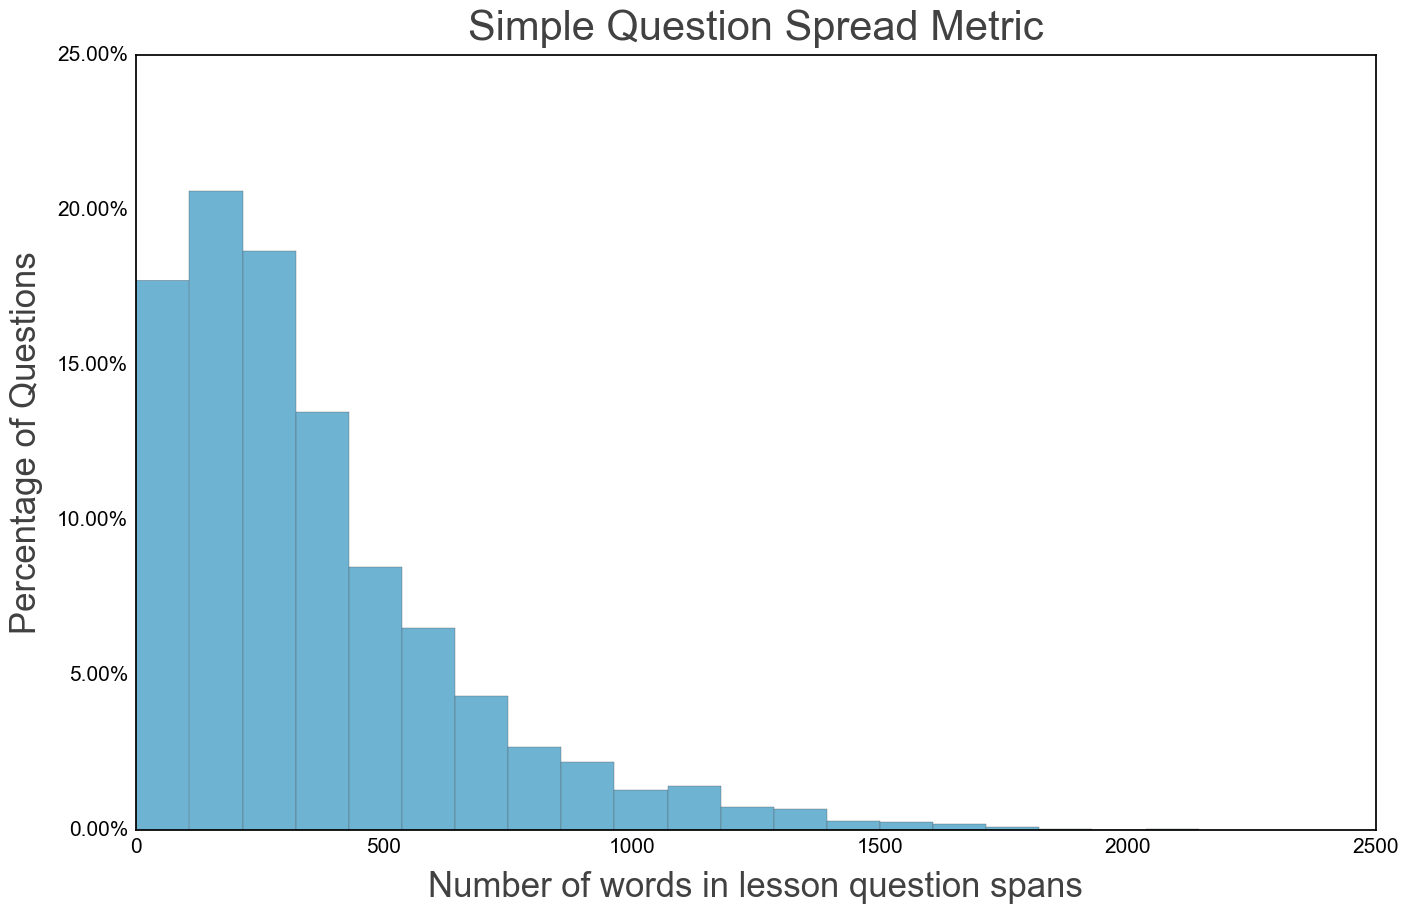

In [683]:
fig_labels = {
    'fig_title': 'Simple Question Spread Metric', 
    'x_label': 'Number of words in lesson question spans',
    'y_label': 'Percentage of Questions'
}

array_to_hist = q_dist_series
weights = np.ones_like(array_to_hist)/len(array_to_hist)
plot_to_save = array_to_hist.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

## hide

In [232]:
# for qid, q in sorted(question_asks.items(), key=lambda x: len(x[1]), reverse=True)[:20]:
#     print(q)
# #     print(mc_questions[qid]['answerChoices'])
#     print()

In [161]:
# plt.scatter(xns, yb, color=b16_colors.g, marker = 'o', s=45)
# plt.plot(xns, lin_mod.predict(np.array(xns).reshape(-1,1)), color=b16_colors.b ,alpha=0.8, linewidth=5.0)
# plt.xlim((0,100))
# plt.ylim((0, 1))
# label_color =  b16_colors.b
# plt.title('Ingredient Cooccurrences', fontsize=50, verticalalignment='bottom', color = label_color)
# plt.ylabel("Fraction of pairs extant", fontsize=30, labelpad=15, color = label_color)
# plt.xlabel("Number of shared flavor compounds", fontsize=30, labelpad=10, color = label_color)
# plt.tick_params(axis='x', which='major', labelsize=20)
# plt.tick_params(axis='y', which='major', labelsize=20)

In [519]:
# def tokenize_question(question_text):
#     q_tokens = wordpunct_tokenize(question_text)
#     normalized_tokens = [toke.strip().lower().encode('ascii', 'ignore').decode() for toke in q_tokens if toke.strip().lower().encode('ascii', 'ignore').decode() not in cached_sw]
#     return normalized_tokens

# def make_and_save_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=b16_colors.b, label_color = '0.25'):
#     if fig_labels:
#         if 'fig_title' in fig_labels:
#             plt.title(fig_labels['fig_title'], fontsize=30, verticalalignment='bottom', color = label_color)
#         if 'y_label' in fig_labels:
#             plt.ylabel(fig_labels['y_label'], fontsize=25, labelpad=10, color = label_color)
#         if 'x_label' in fig_labels:
#             plt.xlabel(fig_labels['x_label'], fontsize=25, labelpad=10, color = label_color)
#     plt.tick_params(axis='x', which='major', labelsize=15)
#     plt.tick_params(axis='y', which='major', labelsize=15)
#     plt.savefig(outfile, bbox_inches='tight')

# def collect_filtered_question_text(question_dict, filter_phrases=None):
#     filtered_questions = {}
#     for phrase in filter_phrases:
#         for qid, question in question_dict.items():
#             question_text = question['beingAsked']['processedText']
#             if phrase in question_text:
#                 filtered_questions[qid] = question_text
#     return filtered_questions

# def make_prop_series(ds_items, property_collector):
#     return(pd.Series([property_collector(item) for item in ds_items.values()]))

# def collect_filtered_lesson_text(complete_ds):
#     filtered_lesson_text = defaultdict(str)
#     for lesson in complete_ds:
#         lesson_key = lesson['lessonName'] + '_' + lesson['globalID']
#         for topic_name, topic in sorted(lesson['topics'].items(), key=lambda x: x[1]['globalID']):
#             if not topic['topicName'] in structural_topics + vocab_topics:
#                 filtered_lesson_text[lesson_key] += topic['content']['text'] 
#     return filtered_lesson_text

# Templates

In [ ]:
fig_labels = {
    'fig_title': '', 
    'x_label': '',
    'y_label': 'Percentage of Questions'
}

array_to_hist = 
weights = np.ones_like(array_to_hist)/len(array_to_hist)
plot_to_save = array_to_hist.hist(bins= 20, log=False, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)